In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import os
import sys
import torch
import warnings
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import itertools
import operator
from transformer_lens import utils, HookedTransformer, ActivationCache


warnings.filterwarnings("ignore")
base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from pyfunctions.cdt_basic import *
from pyfunctions.cdt_source_to_target import *
from pyfunctions.ioi_dataset import IOIDataset
from pyfunctions.wrappers import Node, AblationSet

## Load Model

Note: Unlike with the BERT model + medical dataset objective, it is not necessary to pretrain GPT-2 to perform the IOI dataset.
GPT-2-small is already capable of performing IOI; that's part of the point of the Mech Interp in the Wild paper.
We only need to examine how it does it.

In [13]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.autograd.set_grad_enabled(False)
# Model code adapted from Callum McDougall's notebook for ARENA on reproducing the IOI paper using TransformerLens.

model = HookedTransformer.from_pretrained("gpt2-small",
                                          center_unembed=True,
                                          center_writing_weights=True,
                                          fold_ln=False,
                                          refactor_factored_attn_matrices=True)
                                          

Loaded pretrained model gpt2-small into HookedTransformer


In [14]:
from pyfunctions.ioi_dataset import IOIDataset

# Generate a dataset all consisting of one template, randomly chosen.
# nb_templates = 2 due to some logic internal to IOIDataset:
# essentially, the nouns can be an ABBA or ABAB order and that counts as separate templates.
ioi_dataset = IOIDataset(prompt_type="mixed", N=100, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

# This is the P_ABC that is mentioned in the IOI paper, which we use for mean ablation.
# Importantly, passing in prompt_type="ABC" or similar is NOT the same thing as this.
abc_dataset = (
    ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)

logits, cache = model.run_with_cache(abc_dataset.toks) # run on entire dataset along batch dimension

attention_outputs = [cache['blocks.' + str(i) + '.attn.hook_z'] for i in range(12)]
attention_outputs = torch.stack(attention_outputs, dim=1) # now batch, layer, seq, n_heads, dim_attn
mean_acts = torch.mean(attention_outputs, dim=0)
old_shape = mean_acts.shape
last_dim = old_shape[-2] * old_shape[-1]
new_shape = old_shape[:-2] + (last_dim,)
mean_acts = mean_acts.view(new_shape)
mean_acts.shape

torch.Size([12, 16, 768])

In [15]:
text = ioi_dataset.sentences[0]
encoding = model.tokenizer.encode_plus(text, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)

## Basic word attribution visualization

In [16]:
import functools

ablation_sets = [tuple(Node(0, pos, head) for head in range(12)) for pos in range(16)]
target_nodes = []
out_decomps, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_sets, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)


In [17]:
import matplotlib
from IPython.display import display, HTML
from matplotlib.colors import LinearSegmentedColormap

def normalize_word_scores(word_scores):
    neg_pos_lst = [i for i, x in enumerate(word_scores) if x < 0]
    abs_word_scores = np.abs(word_scores)
    normalized = (abs_word_scores-min(abs_word_scores))/(max(abs_word_scores)-min(abs_word_scores)) # in [0, 1] range
    for i, x in enumerate(normalized):
        if i in neg_pos_lst:
            normalized[i] = -normalized[i]
    return normalized

def colorize(words, color_array, mid=0, eps=1e-03):
    cmap_pos = LinearSegmentedColormap.from_list('', ['white', '#48b6df'])
    cmap_neg = LinearSegmentedColormap.from_list('', ['white', '#dd735b'])
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        if color > mid:
          color = matplotlib.colors.rgb2hex(cmap_pos(color)[:3])
        elif color < mid:
          color = matplotlib.colors.rgb2hex(cmap_neg(abs(color))[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

In [18]:
def get_word_scores(out_decomps, ioi_dataset, data_idx):# calculate the "ioi score": the score of the correct logit minus the score of the subject logit
    logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab]
    io_seq_idx = ioi_dataset.io_tokenIDs[data_idx] 
    s_seq_idx = ioi_dataset.s_tokenIDs[data_idx] 

    io_logit = logits[0, -2, io_seq_idx]
    s_logit = logits[0, -2, s_seq_idx]
    full_score = np.abs(io_logit - s_logit)

    # for each source node determine the contribution of rel to the actual score
    rel_word_scores = []
    irrel_word_scores = []
    Result = collections.namedtuple('Result', ('ablation_set', 'score'))
    for idx, decomp in enumerate(out_decomps):
        assert(idx == decomp.ablation_set[0].sequence_idx)
        rel_io_logit = decomp.rel[0, -2, io_seq_idx]
        rel_s_logit = decomp.rel[0, -2, s_seq_idx]
        rel_score = rel_io_logit - rel_s_logit
        rel_norm_score = rel_score / full_score
        rel_word_scores.append(rel_norm_score)
        irrel_io_logit = decomp.irrel[0, -2, io_seq_idx]
        irrel_s_logit = decomp.irrel[0, -2, s_seq_idx]
        irrel_score = irrel_io_logit - irrel_s_logit
        irrel_norm_score = irrel_score / full_score
        irrel_word_scores.append(irrel_norm_score)
    irrel_word_scores = normalize_word_scores(irrel_word_scores)
    rel_word_scores = normalize_word_scores(rel_word_scores)
    return rel_word_scores, irrel_word_scores


In [19]:
for example_idx in range(10):
    ablation_sets = [tuple(Node(0, pos, head) for head in range(12)) for pos in range(16)]
    target_nodes = []
    text = ioi_dataset.sentences[example_idx]
    encoding = model.tokenizer.encode_plus(text, 
                                     add_special_tokens=True, 
                                     max_length=512,
                                     truncation=True, 
                                     padding = "longest", 
                                     return_attention_mask=True, 
                                     return_tensors="pt").to(device)
    encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
    input_shape = encoding_idxs.size()
    extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                            input_shape, 
                                                            model,
                                                        device)
    out_decomps, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_sets, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)
    rel_word_scores, irrel_word_scores = get_word_scores(out_decomps, ioi_dataset, example_idx)
    tokens = ioi_dataset.tokenized_prompts[example_idx].split('|')[:-1]
    s = colorize(tokens, rel_word_scores[:-1])
    print(rel_word_scores[:-1])
    # s = colorize(tokens, [r - i for (r, i) in zip(rel_word_scores, irrel_word_scores)])
    display(HTML(s))
    

[ 0.07436397  0.03876451 -0.73805434  0.24506804  1.          0.13571976
  0.19179744  0.19574727  0.29995587  0.18604636 -0.2712247   0.24411882
  0.26382306  0.4517916   0.29704818]


[0.43507463 0.4778419  1.         0.31269565 0.05793535 0.25424573
 0.24331325 0.21728188 0.23542954 0.16288966 0.01360347 0.1691294
 0.14401649 0.17321636 0.27041093]


[ 0.2536952   0.22678366  1.          0.25759864 -0.68866783  0.23065329
  0.3589816   0.5456817   0.6522675   0.38197413 -0.26249474  0.48245624
  0.47105092  0.7612788   0.5480921 ]


[ 0.3083021   0.30070636 -0.4211002   0.49709058  1.          0.3441611
  0.3205667   0.32578963  0.22353093  0.33276072 -0.16740575  0.43713266
  0.4161457   0.4547073   0.47529665]


[ 0.02529827 -0.04220118 -1.          0.36790422  0.6752263   0.16661751
  0.19635138  0.30828995  0.24708374  0.20369497 -0.20958103  0.36733842
  0.23307501  0.56892127  0.4051526 ]


[ 0.16913602  0.15589534  0.03553714  0.7302412   1.          0.5224389
  0.43206477  0.36520612  0.37242535  0.2158832  -0.02359545  0.33510745
  0.30915126  0.35466665  0.71634275]


[ 0.27815554  0.360255    0.24522445  0.5546085   1.          0.3087174
  0.22923985  0.25438032  0.24528295  0.14464092 -0.03699344  0.19538142
  0.19714208  0.31787184  0.40613762]


[0.47104433 0.49067464 1.         0.3639814  0.08930448 0.39193964
 0.26499024 0.23272254 0.24466503 0.22228548 0.01402303 0.25515574
 0.20067637 0.29249892 0.35357302]


[ 0.39099416  0.41521445  1.          0.1269134  -0.05528108  0.18092372
  0.13868096  0.16993704  0.0577504   0.14415333 -0.09519038  0.11088928
  0.2040385   0.16772     0.26945266]


[ 0.33601865  0.3715288   1.          0.10475123 -0.20838857  0.22086422
  0.24038157  0.16460824  0.159703    0.12995556 -0.16387478  0.19973615
  0.13347928  0.09879559  0.2356675 ]


# IOI Circuit Analysis and Heatmap Visualization

This is a litle bit different from the analysis done in the circuit discovery notebook. Here we follow the IOI paper's analysis to determine which sequence position to search over, and visualize.

## Relevance of nodes to IOI task objective

In [20]:
num_layers = len(model.blocks)
seq_len = ioi_dataset.toks.shape[1]
num_attention_heads = model.cfg.n_heads

In [21]:
NUM_SAMPLES = 10
import functools

ranges = [
        [layer for layer in range(num_layers)],
        [sequence_position for sequence_position in range(seq_len)],
        [attention_head_idx for attention_head_idx in range(num_attention_heads)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

target_nodes = []

# cache activations for faster batch run
out_decomp, _, _, pre_layer_activations = prop_GPT(ioi_dataset.toks[0:NUM_SAMPLES, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

prop_fn = lambda ablation_list: prop_GPT(ioi_dataset.toks[0:NUM_SAMPLES, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
out_decomps, target_decomps = batch_run(prop_fn, ablation_sets, num_at_time=64 // NUM_SAMPLES)

Running decomposition in batches...: 100%|██████████| 384/384 [01:08<00:00,  5.60it/s]


In [27]:
def score_logits(logits):
    io_logit = logits[range(NUM_SAMPLES), -2, ioi_dataset.io_tokenIDs[0:NUM_SAMPLES]]
    s_logit = logits[range(NUM_SAMPLES), -2, ioi_dataset.s_tokenIDs[0:NUM_SAMPLES]]
    return np.mean(io_logit - s_logit)
    
def compute_logits_decomposition_scores(out_decomps, normalized=False):
    logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab
    full_score = score_logits(logits)
    assert(full_score > 0) # this needs to be replaced with a check higher in the pipeline; GPT2 succeeds at this like 99%+ of the time but not always
    
    results = []
    relevances = np.zeros((num_layers, seq_len, num_attention_heads))

    for layer_idx in range(num_layers):
        for seq_idx in range(seq_len):
            for head_idx in range(num_attention_heads):
                decomp = out_decomps[layer_idx * num_attention_heads * seq_len + seq_idx * num_attention_heads  + head_idx]
                score = score_logits(decomp.rel)
                norm_score = score / full_score
                relevances[layer_idx, seq_idx, head_idx] = norm_score
                if not normalized:
                    results.append(Result(decomp.ablation_set, norm_score))
    if normalized:
        sums_per_layer = np.sum(np.abs(relevances), axis=(1, 2))
        print(sums_per_layer)

        sums_per_layer[sums_per_layer == 0] = -1e-8
        relevances = relevances / np.expand_dims(sums_per_layer, (1, 2))
        for layer_idx in range(num_layers):
            for seq_idx in range(seq_len):
                for head_idx in range(num_attention_heads):
                    decomp = out_decomps[layer_idx * num_attention_heads * seq_len + seq_idx * num_attention_heads  + head_idx]
                    results.append(Result(decomp.ablation_set, relevances[layer_idx, seq_idx, head_idx]))
    results.sort(key=operator.attrgetter('score'), reverse=True)

    return results, relevances

In [29]:
Result = collections.namedtuple('Result', ('ablation_set', 'score'))

def compute_logits_decomposition_scores(out_decomps):
    logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab
    io_logit = logits[0, -2, ioi_dataset.io_tokenIDs[0]]
    s_logit = logits[0, -2, ioi_dataset.s_tokenIDs[0]]
    full_score = np.abs(io_logit - s_logit)
    assert(full_score > 0) # this needs to be replaced with a check higher in the pipeline; GPT2 succeeds at this like 99%+ of the time but not always

    results = []
    
    for decomp in out_decomps:
        rel_io_logit = decomp.rel[0, -2, ioi_dataset.io_tokenIDs[0]]
        rel_s_logit = decomp.rel[0, -2, ioi_dataset.s_tokenIDs[0]]
        score = rel_io_logit - rel_s_logit
        norm_score = score / full_score
        # predicted_probs = torch.nn.functional.softmax(torch.Tensor(decomp.rel[0][-2])).cpu().numpy()
        # score = -np.log(predicted_probs[ioi_dataset.io_tokenIDs[0]]) # KL divergence from one-hot distribution
        results.append(Result(decomp.ablation_set, score))
    results.sort(key=operator.attrgetter('score'), reverse=True)
    return results

In [28]:
Result = collections.namedtuple('Result', ('ablation_set', 'score'))

results, relevances = compute_logits_decomposition_scores(out_decomps)

for result in results[:10]:
    print(result)

Result(ablation_set=(Node(layer_idx=9, sequence_idx=14, attn_head_idx=9),), score=0.48846003)
Result(ablation_set=(Node(layer_idx=9, sequence_idx=14, attn_head_idx=6),), score=0.27684304)
Result(ablation_set=(Node(layer_idx=10, sequence_idx=14, attn_head_idx=6),), score=0.11074269)
Result(ablation_set=(Node(layer_idx=10, sequence_idx=14, attn_head_idx=10),), score=0.10299478)
Result(ablation_set=(Node(layer_idx=10, sequence_idx=14, attn_head_idx=0),), score=0.09857898)
Result(ablation_set=(Node(layer_idx=8, sequence_idx=14, attn_head_idx=10),), score=0.08246716)
Result(ablation_set=(Node(layer_idx=7, sequence_idx=14, attn_head_idx=9),), score=0.08085424)
Result(ablation_set=(Node(layer_idx=8, sequence_idx=14, attn_head_idx=6),), score=0.07790282)
Result(ablation_set=(Node(layer_idx=10, sequence_idx=14, attn_head_idx=1),), score=0.07234371)
Result(ablation_set=(Node(layer_idx=0, sequence_idx=2, attn_head_idx=3),), score=0.06731521)


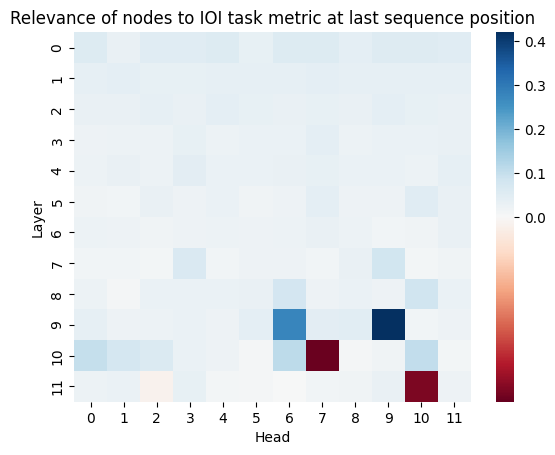

In [30]:
divnorm = colors.TwoSlopeNorm(vmin=-0.07, vcenter=0, vmax=0.42)

s = sns.heatmap(relevances[:, -2, :], xticklabels = range(12), yticklabels = range(12), cmap='RdBu', cbar_kws={'label': ''}, norm=divnorm)
s.set(xlabel='Head', ylabel='Layer')
#token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
plt.title("Relevance of nodes to IOI task metric at last sequence position")
plt.show()

## Relevance of nodes to output residuals of known Name Mover Heads


In [31]:

target_nodes = [Node(9, 14, 9), Node(9, 14, 6), Node(10, 14, 0)]

ranges = [
        [layer for layer in range(12)],
        [14],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

_, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
_, target_decomps = batch_run(prop_fn, ablation_sets)


Running decomposition in batches...: 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]


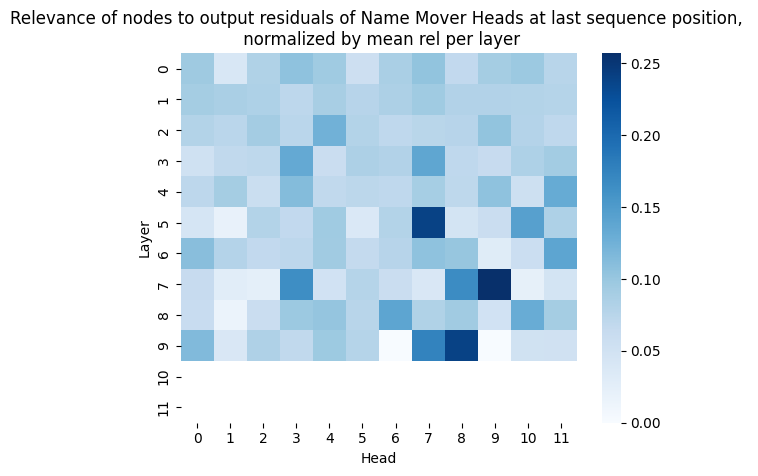

In [32]:
relevances = np.zeros((12, 12))

for layer_idx in range(12):
    for head_idx in range(12):
        score = 0
        target_decomp = target_decomps[12 * layer_idx + head_idx]
        
        for i in range(len(target_decomp.target_nodes)):
            rels_magnitude = torch.mean(abs(target_decomp.rels[i])) # np.mean if you are on cpu
            irrels_magnitude = torch.mean(abs(target_decomp.irrels[i])) # np.mean if you are on cpu
            target_node_score = rels_magnitude / (rels_magnitude + irrels_magnitude)
            score += (target_node_score)
        if target_decomp.ablation_set[0] in target_nodes:
            score = 0
        relevances[layer_idx, head_idx] = score

sums_per_layer = np.sum(relevances, axis=1)
normalized_relevances = relevances / np.expand_dims(sums_per_layer, 1)

s = sns.heatmap(normalized_relevances, xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
#token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
plt.title("Relevance of nodes to output residuals of Name Mover Heads at last sequence position, \n normalized by mean rel per layer")
plt.show()

In [33]:
Result = collections.namedtuple('Result', ('ablation_set', 'score'))
results = []
for layer_idx in range(12):
    for head_idx in range(12):
        results.append(Result(Node(layer_idx, ioi_dataset.word_idx['end'][0], head_idx), normalized_relevances[layer_idx, head_idx]))

results.sort(key=operator.attrgetter('score'), reverse=True)
for result in results[:20]:
    print(result)
# 7.3, 7.9, 8.6, 8.10

Result(ablation_set=Node(layer_idx=7, sequence_idx=tensor(14), attn_head_idx=9), score=0.25717571266202555)
Result(ablation_set=Node(layer_idx=9, sequence_idx=tensor(14), attn_head_idx=8), score=0.23994115511370334)
Result(ablation_set=Node(layer_idx=5, sequence_idx=tensor(14), attn_head_idx=7), score=0.23920631825964506)
Result(ablation_set=Node(layer_idx=9, sequence_idx=tensor(14), attn_head_idx=7), score=0.17575054080979496)
Result(ablation_set=Node(layer_idx=7, sequence_idx=tensor(14), attn_head_idx=8), score=0.16673427947989616)
Result(ablation_set=Node(layer_idx=7, sequence_idx=tensor(14), attn_head_idx=3), score=0.16405031888508825)
Result(ablation_set=Node(layer_idx=5, sequence_idx=tensor(14), attn_head_idx=10), score=0.1444256412174001)
Result(ablation_set=Node(layer_idx=6, sequence_idx=tensor(14), attn_head_idx=11), score=0.13958961310228513)
Result(ablation_set=Node(layer_idx=8, sequence_idx=tensor(14), attn_head_idx=6), score=0.13895265515931438)
Result(ablation_set=Node(la

## Relevance of nodes to output residuals of known S-inhibition heads

In [34]:
s2_pos = ioi_dataset.word_idx['S2'][0]
target_nodes = [Node(8, 14, 10), Node(7, 14, 9), Node(7, 14, 3)]

ranges = [
        [layer for layer in range(12)],
        [s2_pos],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

_, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
_, target_decomps = batch_run(prop_fn, ablation_sets)


Running decomposition in batches...: 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]


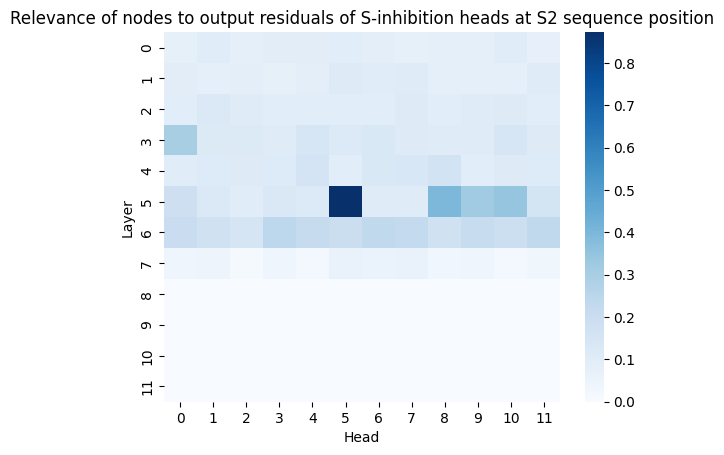

In [35]:
relevances = np.zeros((12, 12))

for layer_idx in range(12):
    for head_idx in range(12):
        score = 0
        target_decomp = target_decomps[12 * layer_idx + head_idx]
        
        for i in range(len(target_decomp.target_nodes)):
            rels_magnitude = torch.mean(abs(target_decomp.rels[i])) # np.mean if you are on cpu
            irrels_magnitude = torch.mean(abs(target_decomp.irrels[i])) # np.mean if you are on cpu
            target_node_score = rels_magnitude / (rels_magnitude + irrels_magnitude)
            score += (target_node_score) * (1.5 ** target_decomp.ablation_set[0].layer_idx)
        if target_decomp.ablation_set[0] in target_nodes:
            score = 0
        relevances[layer_idx, head_idx] = score

# sums_per_layer = np.sum(relevances, axis=1)
# normalized_relevances = relevances / np.expand_dims(sums_per_layer, 1)

s = sns.heatmap(relevances, xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
#token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
plt.title("Relevance of nodes to output residuals of S-inhibition heads at S2 sequence position")
# 5.5, 6.9, (5.8, 5.9)
plt.show()

In [36]:
Result = collections.namedtuple('Result', ('ablation_set', 'score'))
results = []
for layer_idx in range(12):
    for head_idx in range(12):
        results.append(Result(Node(layer_idx, ioi_dataset.word_idx['S2'][0], head_idx), relevances[layer_idx, head_idx]))

results.sort(key=operator.attrgetter('score'), reverse=True)
for result in results[:20]:
    print(result)
# 5.5, 6.9, (5.8, 5.9)

Result(ablation_set=Node(layer_idx=5, sequence_idx=tensor(10), attn_head_idx=5), score=0.8729332685470581)
Result(ablation_set=Node(layer_idx=5, sequence_idx=tensor(10), attn_head_idx=8), score=0.39583730697631836)
Result(ablation_set=Node(layer_idx=5, sequence_idx=tensor(10), attn_head_idx=10), score=0.34618183970451355)
Result(ablation_set=Node(layer_idx=5, sequence_idx=tensor(10), attn_head_idx=9), score=0.3230088949203491)
Result(ablation_set=Node(layer_idx=3, sequence_idx=tensor(10), attn_head_idx=0), score=0.3023454248905182)
Result(ablation_set=Node(layer_idx=6, sequence_idx=tensor(10), attn_head_idx=3), score=0.24426421523094177)
Result(ablation_set=Node(layer_idx=6, sequence_idx=tensor(10), attn_head_idx=11), score=0.2329939901828766)
Result(ablation_set=Node(layer_idx=6, sequence_idx=tensor(10), attn_head_idx=6), score=0.23216098546981812)
Result(ablation_set=Node(layer_idx=6, sequence_idx=tensor(10), attn_head_idx=7), score=0.22476541996002197)
Result(ablation_set=Node(layer

Running decomposition in batches...: 100%|██████████| 3/3 [00:00<00:00,  7.63it/s]


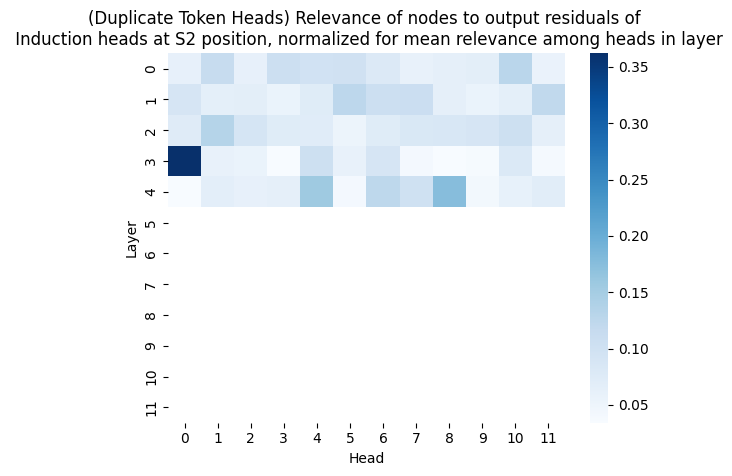

In [37]:
s2_pos = ioi_dataset.word_idx['S2'][0]
target_nodes = [Node(5, s2_pos, 5), Node(5, s2_pos, 8), Node(5, s2_pos, 9)] # here we assume that we only ever tried to ablate one node at once; our method doesn't handle anything else

ranges = [
        [layer for layer in range(12)],
        # [sequence_position for sequence_position in range(input_shape[1])],
        [s2_pos],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

_, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:NUM_SAMPLES, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:NUM_SAMPLES, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
_, target_decomps = batch_run(prop_fn, ablation_sets)
relevances = np.zeros((12, 12))

for layer_idx in range(12):
    for head_idx in range(12):
        score = 0
        target_decomp = target_decomps[12 * layer_idx + head_idx]
        
        for i in range(len(target_decomp.target_nodes)):
            rels_magnitude = torch.mean(abs(target_decomp.rels[i])) # np.mean if you are on cpu
            irrels_magnitude = torch.mean(abs(target_decomp.irrels[i])) # np.mean if you are on cpu
            target_node_score = rels_magnitude / (rels_magnitude + irrels_magnitude)
            score += (target_node_score)
        
        if target_decomp.ablation_set[0] in target_nodes:
            score = 0
        relevances[layer_idx, head_idx] = score
sums_per_layer = np.sum(np.abs(relevances), axis=1)
relevances = relevances / np.expand_dims(sums_per_layer, 1)

# s = sns.heatmap(normalized_relevances, xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s = sns.heatmap(relevances, xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
#token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
plt.title("(Duplicate Token Heads) Relevance of nodes to output residuals of \n Induction heads at S2 position, normalized for mean relevance among heads in layer")
# (2, 2), (4, 11)
plt.show()

In [38]:
Result = collections.namedtuple('Result', ('ablation_set', 'score'))
results = []
for layer_idx in range(12):
    for head_idx in range(12):
        results.append(Result(Node(layer_idx, ioi_dataset.word_idx['S2'][0], head_idx), relevances[layer_idx, head_idx]))

results.sort(key=operator.attrgetter('score'), reverse=True)
for result in results[:20]:
    print(result)
# 3.0 (already found in previous iter), 0.1, (0.10)

Result(ablation_set=Node(layer_idx=3, sequence_idx=tensor(10), attn_head_idx=0), score=0.3622478647590055)
Result(ablation_set=Node(layer_idx=4, sequence_idx=tensor(10), attn_head_idx=8), score=0.17629819369528532)
Result(ablation_set=Node(layer_idx=4, sequence_idx=tensor(10), attn_head_idx=4), score=0.15607552666890404)
Result(ablation_set=Node(layer_idx=2, sequence_idx=tensor(10), attn_head_idx=1), score=0.13382738311614487)
Result(ablation_set=Node(layer_idx=0, sequence_idx=tensor(10), attn_head_idx=10), score=0.12847315526517963)
Result(ablation_set=Node(layer_idx=1, sequence_idx=tensor(10), attn_head_idx=5), score=0.12552376609703023)
Result(ablation_set=Node(layer_idx=4, sequence_idx=tensor(10), attn_head_idx=6), score=0.12397762648655711)
Result(ablation_set=Node(layer_idx=1, sequence_idx=tensor(10), attn_head_idx=11), score=0.12259975582241427)
Result(ablation_set=Node(layer_idx=0, sequence_idx=tensor(10), attn_head_idx=1), score=0.11471334264726586)
Result(ablation_set=Node(la

Running decomposition in batches...: 100%|██████████| 3/3 [00:00<00:00,  7.51it/s]


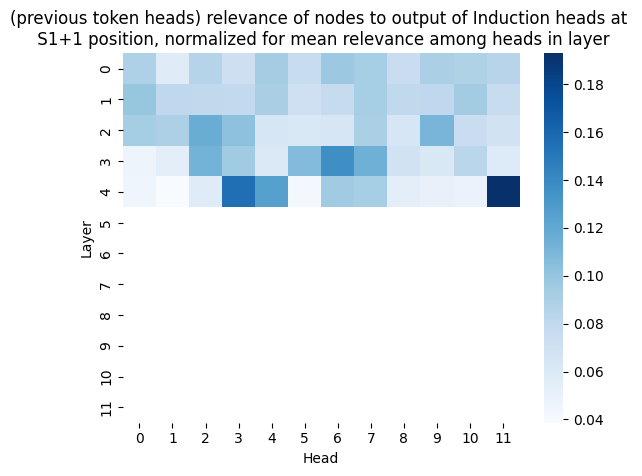

In [39]:
sp1_pos = ioi_dataset.word_idx['S+1'][0]
target_nodes = [Node(5, s2_pos, 5), Node(5, s2_pos, 8), Node(5, s2_pos, 9)] # here we assume that we only ever tried to ablate one node at once; our method doesn't handle anything else

ranges = [
        [layer for layer in range(12)],
        # [sequence_position for sequence_position in range(input_shape[1])],
        [sp1_pos],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

_, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:NUM_SAMPLES, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:NUM_SAMPLES, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
_, target_decomps = batch_run(prop_fn, ablation_sets)

relevances = np.zeros((12, 12))

for layer_idx in range(12):
    for head_idx in range(12):
        score = 0
        target_decomp = target_decomps[12 * layer_idx + head_idx]
        
        for i in range(len(target_decomp.target_nodes)):
            rels_magnitude = torch.mean(abs(target_decomp.rels[i])) # np.mean if you are on cpu
            irrels_magnitude = torch.mean(abs(target_decomp.irrels[i])) # np.mean if you are on cpu
            target_node_score = rels_magnitude / (rels_magnitude + irrels_magnitude)
            score += (target_node_score)
        
        if target_decomp.ablation_set[0] in target_nodes:
            score = 0
        relevances[layer_idx, head_idx] = score

sums_per_layer = np.sum(np.abs(relevances), axis=1)
relevances = relevances / np.expand_dims(sums_per_layer, 1)

s = sns.heatmap(relevances, xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
#token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
plt.title("(previous token heads) relevance of nodes to output of Induction heads at \n S1+1 position, normalized for mean relevance among heads in layer")
# (2, 2), (4, 11)
plt.show()

In [40]:
Result = collections.namedtuple('Result', ('ablation_set', 'score'))
results = []
for layer_idx in range(12):
    for head_idx in range(12):
        results.append(Result(Node(layer_idx, ioi_dataset.word_idx['S2'][0], head_idx), relevances[layer_idx, head_idx]))

results.sort(key=operator.attrgetter('score'), reverse=True)
for result in results[:20]:
    print(result)

Result(ablation_set=Node(layer_idx=4, sequence_idx=tensor(10), attn_head_idx=11), score=0.1930626220355531)
Result(ablation_set=Node(layer_idx=4, sequence_idx=tensor(10), attn_head_idx=3), score=0.15524305625242693)
Result(ablation_set=Node(layer_idx=3, sequence_idx=tensor(10), attn_head_idx=6), score=0.13638571224507742)
Result(ablation_set=Node(layer_idx=4, sequence_idx=tensor(10), attn_head_idx=4), score=0.12589250732368137)
Result(ablation_set=Node(layer_idx=2, sequence_idx=tensor(10), attn_head_idx=2), score=0.11665340623090412)
Result(ablation_set=Node(layer_idx=3, sequence_idx=tensor(10), attn_head_idx=7), score=0.11425287046866484)
Result(ablation_set=Node(layer_idx=3, sequence_idx=tensor(10), attn_head_idx=2), score=0.11259173090101209)
Result(ablation_set=Node(layer_idx=2, sequence_idx=tensor(10), attn_head_idx=9), score=0.11054713023598815)
Result(ablation_set=Node(layer_idx=3, sequence_idx=tensor(10), attn_head_idx=5), score=0.10720688084971393)
Result(ablation_set=Node(lay

Running decomposition in batches...: 100%|██████████| 3/3 [00:00<00:00,  8.03it/s]


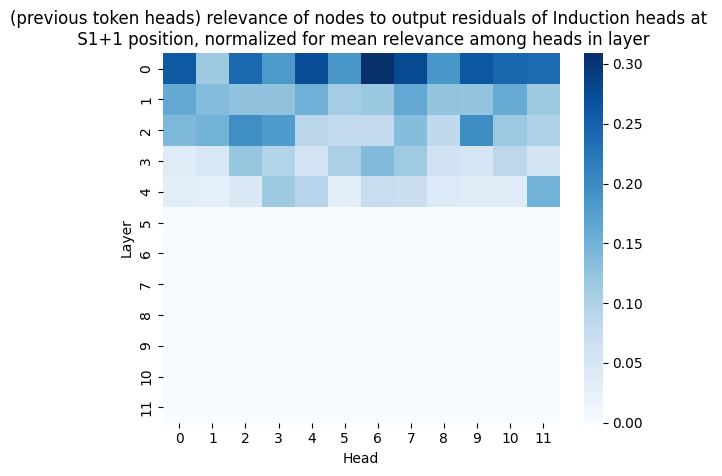

In [41]:
s2_pos = ioi_dataset.word_idx['S+1'][0]
target_nodes = [Node(5, s2_pos, 5), Node(5, s2_pos, 8), Node(5, s2_pos, 9)] # here we assume that we only ever tried to ablate one node at once; our method doesn't handle anything else

ranges = [
        [layer for layer in range(12)],
        # [sequence_position for sequence_position in range(input_shape[1])],
        [s2_pos],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes]

_, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations, target_decomp_method='residual')
_, target_decomps = batch_run(prop_fn, ablation_sets)

relevances = np.zeros((12, 12))

for layer_idx in range(12):
    for head_idx in range(12):
        score = 0
        target_decomp = target_decomps[12 * layer_idx + head_idx]
        
        for i in range(len(target_decomp.target_nodes)):
            rels_magnitude = torch.mean(abs(target_decomp.rels[i])) # np.mean if you are on cpu
            irrels_magnitude = torch.mean(abs(target_decomp.irrels[i])) # np.mean if you are on cpu
            target_node_score = rels_magnitude / (rels_magnitude + irrels_magnitude)
            score += (target_node_score)
        
        if target_decomp.ablation_set[0] in target_nodes:
            score = 0
        relevances[layer_idx, head_idx] = score

# relevances[0:5] /= np.expand_dims(np.sum(relevances[0:5], axis=1),1)

s = sns.heatmap(relevances, xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
#token = ioi_dataset.tokenized_prompts[0].split('|')[seq_idx]
plt.title("(previous token heads) relevance of nodes to output residuals of Induction heads at \n S1+1 position, normalized for mean relevance among heads in layer")
# (2, 2), (4, 11)
plt.show()

In [42]:
Result = collections.namedtuple('Result', ('ablation_set', 'score'))
results = []
for layer_idx in range(12):
    for head_idx in range(12):
        results.append(Result(Node(layer_idx, ioi_dataset.word_idx['S+1'][0], head_idx), relevances[layer_idx, head_idx]))

results.sort(key=operator.attrgetter('score'), reverse=True)
for result in results[:20]:
    print(result)
# (2, 2), (4, 11)

Result(ablation_set=Node(layer_idx=0, sequence_idx=tensor(3), attn_head_idx=6), score=0.30907273292541504)
Result(ablation_set=Node(layer_idx=0, sequence_idx=tensor(3), attn_head_idx=7), score=0.27856943011283875)
Result(ablation_set=Node(layer_idx=0, sequence_idx=tensor(3), attn_head_idx=4), score=0.274776428937912)
Result(ablation_set=Node(layer_idx=0, sequence_idx=tensor(3), attn_head_idx=9), score=0.2630094587802887)
Result(ablation_set=Node(layer_idx=0, sequence_idx=tensor(3), attn_head_idx=0), score=0.2595338225364685)
Result(ablation_set=Node(layer_idx=0, sequence_idx=tensor(3), attn_head_idx=10), score=0.24395176768302917)
Result(ablation_set=Node(layer_idx=0, sequence_idx=tensor(3), attn_head_idx=2), score=0.24110811948776245)
Result(ablation_set=Node(layer_idx=0, sequence_idx=tensor(3), attn_head_idx=11), score=0.24018368124961853)
Result(ablation_set=Node(layer_idx=2, sequence_idx=tensor(3), attn_head_idx=9), score=0.1971157193183899)
Result(ablation_set=Node(layer_idx=2, se